<a href="https://colab.research.google.com/github/arjan-hada/antibody-binding-affinity/blob/main/01_ml_antibody_bind_affinity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine learning guided binding affinity prediction from antibody libraries - 2

In the previous notebook, we evaluated the performance of different pretrained protein language models on predicting the binding affinity (Kd) between scFv variants and the target pepetide. This notebook aims to build upon those initial findings by exploring alternative data processing strategies that may enhance our model's performance metrics. We will also conduct error analysis to understand the behavior and performance of our model more comprehensively.

## Setup

In [1]:
# Setup block for Colab
# Install necessary libraries for the project
!pip install python-Levenshtein evaluate datasets transformers[torch] rjieba &> /dev/null
!apt install git-lfs &> /dev/null

In [2]:
# To share your model with the community
# First store your authentication token from the Hugging Face website and then execute this cell
# Make sure to get token with WRITE access
from huggingface_hub import notebook_login

notebook_login()

In [3]:
# Import necessary libraries
from pathlib import Path
import os
from urllib.request import urlretrieve

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set_context(context="paper", font_scale=1.5)

import Levenshtein

from torch.utils.data import Dataset, DataLoader, random_split
import warnings,transformers,logging,torch
from transformers import TrainingArguments,Trainer
from transformers import AutoModelForSequenceClassification, AutoTokenizer

import datasets
from datasets import load_dataset, Dataset, DatasetDict

In [4]:
# HuggingFace Transformers spits out lots of warnings, so let's quieten it down:
warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

## Data loading and processing

In [5]:
### Step 1: Define Utility Functions
from pathlib import Path
from urllib.request import urlretrieve
import pandas as pd

def download_file(url, path):
    """Downloads and saves the file only if it does not already exist."""
    if not path.exists():
        urlretrieve(url, path)
        print(f"Downloaded {path}")
    else:
        print(f"File already exists at {path}")

def load_data(paths):
    """Load data from CSV files into Pandas DataFrames."""
    return {key: pd.read_csv(path) for key, path in paths.items()}

def handle_missing_values(dfs, group_col='mata_description', target_col='pred_aff', filter_nan='drop'):
    """
    Handles missing values in a dictionary of DataFrames by either dropping them or filling them
    with the median of groups with less than 3 non-NaN entries. It processes 'train', 'valid',
    and 'test' datasets as provided in the dictionary 'dfs'.

    Parameters:
        dfs (dict): Dictionary containing the dataframes under keys 'train', 'valid', 'test'.
        group_col (str): The column to group by.
        target_col (str): The column for which the median is calculated.
        filter_nan (str): The method to handle NaN values ('drop' or 'median').
    """
    data_all = pd.concat(dfs.values())

    # Exclude sequence where all replicates contained NaN in target_col
    dfs['test'] = dfs['test'].groupby(group_col).filter(lambda x: x[target_col].notna().sum() > 0)

    if filter_nan == 'drop':
        for key, df in dfs.items():
            dfs[key] = df.dropna(subset=[target_col])
    elif filter_nan == 'median':
        # Drop NaN values and calculate medians for groups with less than 3 non-NaN entries.
        non_nan_data = data_all.dropna(subset=[target_col])
        medians = non_nan_data.groupby(group_col).filter(lambda x: len(x) < 3)[target_col].median()

        for key, df in dfs.items():
            dfs[key][target_col] = df[target_col].fillna(medians)

    return dfs

def process_replicates(dataframes, group_col='mata_description', target_col='pred_aff'):
    """Calculate mean of replicates and drop duplicates."""
    for df in dataframes.values():
        df[target_col] = df.groupby(group_col)[target_col].transform('mean')
        df.drop_duplicates(subset=[group_col], inplace=True)

def add_static_sequences(dataframes, aa_col='aa_seq', left_seq='', right_seq=''):
    """Add static sequences to amino acid sequences."""
    for df in dataframes.values():
        df['hc'] = left_seq + df[aa_col].astype(str) + right_seq

In [6]:
### Step 2: Setup Paths and URLs
urls = {
    'train': 'https://raw.githubusercontent.com/AIforGreatGood/biotransfer/main/example_data/covid/replicate_corrected/14H/14H_train.csv',
    'valid': 'https://raw.githubusercontent.com/AIforGreatGood/biotransfer/main/example_data/covid/replicate_corrected/14H/14H_valid.csv',
    'test': 'https://raw.githubusercontent.com/AIforGreatGood/biotransfer/main/example_data/covid/replicate_corrected/14H/14H_test.csv'
}

path_data = Path('data')
path_data.mkdir(exist_ok=True)
paths = {key: path_data / f'14H_{key}.csv' for key in urls}

In [7]:
### Step 3: Download and Load Data

for key, url in urls.items():
    download_file(url, paths[key])

df_dict = load_data(paths)

File already exists at data/14H_train.csv
File already exists at data/14H_valid.csv
File already exists at data/14H_test.csv


In [8]:
wt_14VH = 'EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPEWVSVIYSDGRRTFYGDSVKGRFTISRDTSTNTVYLQMNSLRVEDTAVYYCAKGRAAGTFDSWGQGTLVTVSS'
static_left = 'EVQLVETGGGLVQPGGSLRLSCAAS'
static_right = 'WGQGTLVTVSS'
mutation_window = 'GFTLNSYGISWVRQAPGKGPEWVSVIYSDGRRTFYGDSVKGRFTISRDTSTNTVYLQMNSLRVEDTAVYYCAKGRAAGTFDS'

## Training preparation

### Defining the performance metrics

In [9]:
from evaluate import load
import numpy as np

metric_spearmanr = load("spearmanr")

def compute_metrics(eval_pred):
    """
    Compute Spearman's rank correlation coefficient between the predicted and
    actual labels
    """
    predictions, labels = eval_pred
    return metric_spearmanr.compute(predictions=predictions, references=labels)

### Tokenizer, Dataset, Trainer

For quicker iteration we will create some functions to try different pretrained models and trainer parameters.

In [10]:
def tok_func(example, tokenizer, inp_col):
    """
    Tokenizes input data using a predefined tokenizer.
    `Dataset.map` needs this function.
    """
    # a dictionary containing 'input_ids' and other tensors like 'attention_mask'
    return tokenizer(example[inp_col], return_tensors='pt')

In [11]:
def get_tok_dds(df_dict, tokenizer, inp_col, label_col):
    """
    Converts a dictionary of pandas DataFrames to a Hugging Face DatasetDict
    and tokenizes it.
    """

    # convert pandas DataFrames into HuggingFace Datasets
    # rename the labels column to what Transformers expects for the dependent variable, which is labels
    dds = {}
    for key, df in df_dict.items():
        ds = Dataset.from_pandas(df).rename_column(label_col, 'labels')
        dds[key] = ds

    dds = DatasetDict(dds)

    fields = list(dds['train'].column_names)
    fields.remove('labels') # list containing the columns we no longer need

    # tokenize the input, use batching to speed it up, and remove the columns we no longer need
    tok_dds = dds.map(lambda x: tok_func(x, tokenizer, inp_col),
                      batched=True,
                      remove_columns=fields)
    return tok_dds

In [12]:
def get_trainer(tok_dds, model, tokenizer, model_name='outputs',
                lr=2e-5, bs=32, epochs=5, wd=0.01):
    """
    Returns a Hugging Face Trainer instance with specified training arguments and datasets.
    """
    args = TrainingArguments(
        output_dir=model_name,
        learning_rate=lr,
        per_device_train_batch_size=bs,
        per_device_eval_batch_size=bs * 2,
        num_train_epochs=epochs,
        weight_decay=wd,
        fp16=True, # much faster on modern GPUs and saves some memory
        warmup_ratio=0.1,
        lr_scheduler_type="cosine", # cosine scheduler with warmup
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model='spearmanr',
        greater_is_better=True,
        push_to_hub=True,
    )
    return Trainer(model, args, train_dataset=tok_dds['train'],
                   eval_dataset=tok_dds['valid'], tokenizer=tokenizer,
                   compute_metrics=compute_metrics)

In [13]:
import gc # Python's garbage collection module

def clear_memory():
    gc.collect() # explicitly triggers garbage collection, free up memory
    if torch.cuda.is_available(): torch.cuda.empty_cache() # clears the PyTorch CUDA memory cache

## Training: Drop NA and No replicate aggregation

### Data processing

In [43]:
### Step 4: Data Processing
import copy
# Create deep copies of the DataFrames
dfs_copies1 = {key: df.copy() for key, df in df_dict.items()}

handle_missing_values(dfs_copies1, filter_nan='drop')
add_static_sequences(dfs_copies1, left_seq='EVQLVETGGGLVQPGGSLRLSCAAS', right_seq='WGQGTLVTVSS')

# Output processed data
for key, df in dfs_copies1.items():
    print(f"Processed data for {key}: {df.shape[0]} entries")

Processed data for train: 20547 entries
Processed data for valid: 2606 entries
Processed data for test: 2576 entries


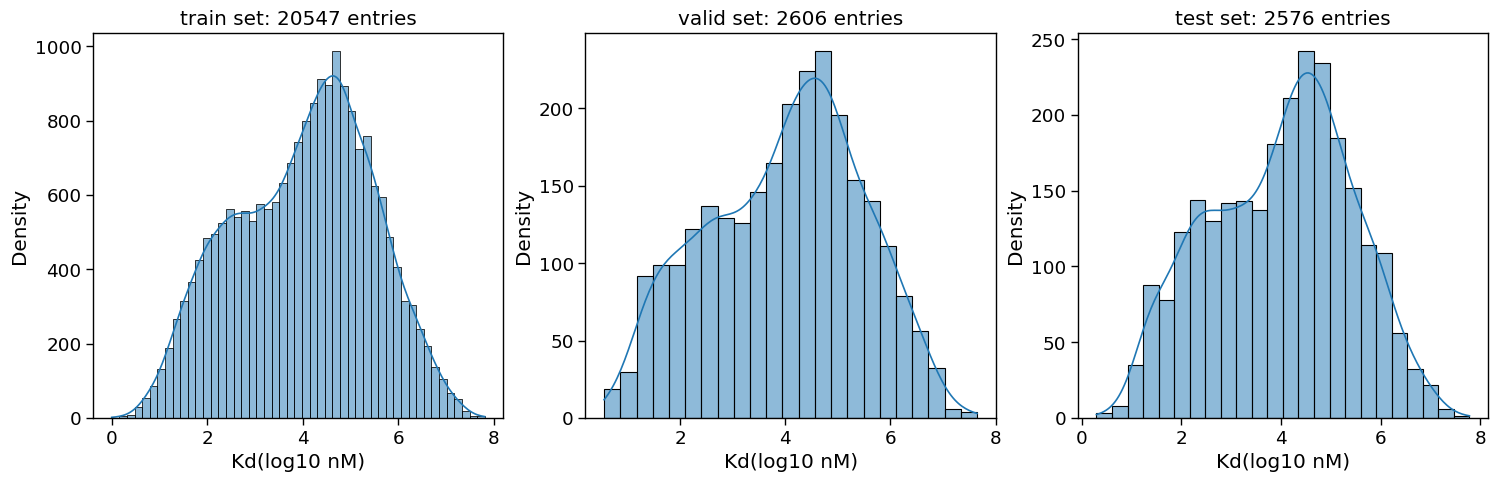

In [44]:
# Set up the matplotlib figure
plt.figure(figsize=(18, 5))

for i, (key, df) in enumerate(dfs_copies1.items()):
    # First scatter plot:
    plt.subplot(1, len(dfs_copies1.items()), i+1)
    sns.histplot(df['pred_aff'].values, kde=True)
    plt.xlabel('Kd(log10 nM)')
    plt.ylabel('Density')
    plt.title(f"{key} set: {df.shape[0]} entries");

### Training

In [45]:
clear_memory()

model_ckpt = 'facebook/esm2_t33_650M_UR50D'
tokz = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                           num_labels=1)

tok_dds = get_tok_dds(dfs_copies1, tokz, inp_col='hc', label_col='pred_aff')

Map:   0%|          | 0/20547 [00:00<?, ? examples/s]

Map:   0%|          | 0/2606 [00:00<?, ? examples/s]

Map:   0%|          | 0/2576 [00:00<?, ? examples/s]

In [46]:
model_name = model_ckpt.split("/")[-1]
trainer = get_trainer(tok_dds, model, tokz,
                      model_name=f"{model_name}-finetuned-Ab14H-v1",
                      lr=2e-5, bs=32, epochs=5, wd=0.01)
trainer.train()

Epoch,Training Loss,Validation Loss,Spearmanr
1,3.065800,1.267716,0.634738
2,1.318500,1.177975,0.650184
3,1.186700,1.136824,0.656756
4,1.008700,1.088918,0.663984
5,0.864000,1.104520,0.661828


TrainOutput(global_step=3215, training_loss=1.3839398041483404, metrics={'train_runtime': 1190.2291, 'train_samples_per_second': 86.315, 'train_steps_per_second': 2.701, 'total_flos': 4.81539271571784e+16, 'train_loss': 1.3839398041483404, 'epoch': 5.0})

In [47]:
# Saves the best model
trainer.save_model("models/esm2_t33_650M_UR50D-finetuned-Ab14H-v1")

In [48]:
# save the model to Hugging Face Hub
trainer.push_to_hub(commit_message="Training completed!")

CommitInfo(commit_url='https://huggingface.co/arjan-hada/esm2_t33_650M_UR50D-finetuned-Ab14H-v1/commit/aa80886280e75f985e674c6daf9b29ca01049991', commit_message='Training completed!', commit_description='', oid='aa80886280e75f985e674c6daf9b29ca01049991', pr_url=None, pr_revision=None, pr_num=None)

### Plot training results

We extract training metrics from the training history, plot training and validation loss alongside the chosen performance metric, and visualize actual vs. predicted results to assess the model's accuracy.

In [49]:
def extract_training_metrics(history):
    """
    Extracts training metrics from a history list which includes loss, evaluation loss,
    and a specified performance metric.

    Args:
        history (list of dicts): A list containing dictionaries for each training and
        evaluation epoch. Each dictionary includes keys for losses and potentially other
        performance metrics.

    Returns:
        tuple: Contains lists of:
            - loss (list): Training loss for each logged epoch.
            - epochs_loss (list): Epoch numbers corresponding to each training loss entry.
            - val_loss (list): Validation loss for each logged epoch.
            - epochs_val_loss (list): Epoch numbers corresponding to each validation loss entry.
            - metrics (list): Values of a specified performance metric for each epoch,
              which could be either Spearman's rho or accuracy, depending on what was measured.

    Example of usage:
        history = trainer.state.log_history
        loss, epochs_loss, val_loss, epochs_val_loss, metrics = extract_training_metrics(history)
    """
    # Initialize lists to hold extracted metrics
    loss, epochs_loss, val_loss, epochs_val_loss, metrics = [], [], [], [], []

    # Determine the key for the performance metric based on the available data in history
    metric_key = 'eval_spearmanr' if any('eval_spearmanr' in x for x in history) else 'eval_accuracy'

    for entry in history:
        if 'loss' in entry:
            loss.append(entry['loss'])
            epochs_loss.append(entry['epoch'])  # Append the epoch number, handle missing cases
        if 'eval_loss' in entry:
            val_loss.append(entry['eval_loss'])  # Append the validation loss value
            epochs_val_loss.append(entry['epoch'])  # Append the epoch number for validation loss
        if metric_key in entry:
            metrics.append(entry[metric_key])  # Append the performance metric value

    return loss, epochs_loss, val_loss, epochs_val_loss, metrics

In [50]:
def plot_training_history(loss, epochs_loss, val_loss, epochs_val_loss, metrics,
                          metric_name='Metric'):
    """
    Plots the training history including both loss and a specific performance metric.

    Args:
        loss (list): List of loss values across epochs.
        epochs_loss (list): List of epochs corresponding to the loss values.
        val_loss (list): List of validation loss values across epochs.
        epochs_val_loss (list): List of epochs corresponding to the validation loss values.
        metrics (list): List of metric values across epochs.
        metric_name (str): The name of the metric being plotted (e.g., 'Spearman', 'Accuracy').

    The ylim for the metric axis is set to range from 0 to 1, which may need adjustment depending
    on the metric scale. Users should ensure the metric range is appropriate or modify this setting as needed.
    """
    if not metrics:
        print("Metric data is empty. Skipping metric plot.")
        return

    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()

    # Plotting
    ax1.plot(epochs_loss, loss, label='Train Loss', color='blue')
    ax1.plot(epochs_val_loss, val_loss, label='Validation Loss', color='green')
    ax2.plot(epochs_val_loss, metrics, color='red', label=f'Validation {metric_name}')

    # Setting labels
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax2.set_ylabel(metric_name)
    ax2.set_ylim([0, 1])  # This might need adjustment based on metric scale

    # Creating a combined legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper left')

    plt.title("Training History")
    plt.show()

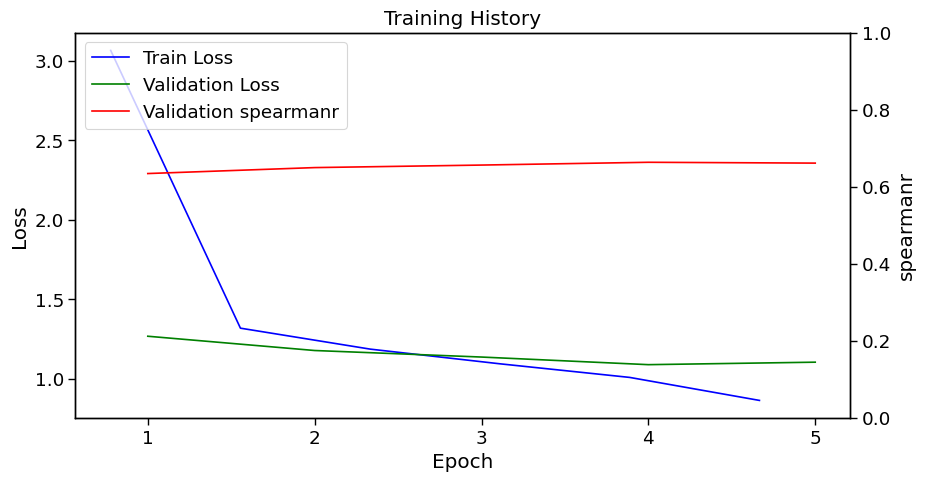

In [51]:
# Extract and plot training metrics
history = trainer.state.log_history
loss, epochs_loss, val_loss, epochs_val_loss, metrics = extract_training_metrics(history)
plot_training_history(loss, epochs_loss, val_loss, epochs_val_loss, metrics, metric_name='spearmanr')

In [52]:
# Predict on eval dataset and plot results
preds_output_eval = trainer.predict(tok_dds["valid"])
print("Test Spearman r:", preds_output_eval.metrics['test_spearmanr'])

Test Spearman r: 0.6639844751197583


In [53]:
from scipy import stats
def plot_prediction_error(actuals, predictions):
    # Calculate residuals
    residuals = actuals - predictions
    spearman_corr = stats.spearmanr(actuals, predictions).correlation

    # Set up the matplotlib figure
    fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

    # Actual vs. Predicted scatter plot
    sns.scatterplot(x=predictions, y=actuals, ax=axs[0], alpha=0.6)
    axs[0].plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--')  # Diagonal line
    axs[0].set_title(f'Actual vs Predicted\nSpearman r: {spearman_corr:.4f}')
    axs[0].set_xlabel('Predicted Values')
    axs[0].set_ylabel('Actual Values')

    # Residuals scatter plot
    sns.scatterplot(x=predictions, y=residuals, ax=axs[1], alpha=0.6)
    axs[1].axhline(0, color='red', linestyle='--')  # Line at 0 for residuals
    axs[1].set_title('Residuals vs Predicted')
    axs[1].set_xlabel('Predicted Values')
    axs[1].set_ylabel('Residuals')

    plt.tight_layout()
    plt.show()

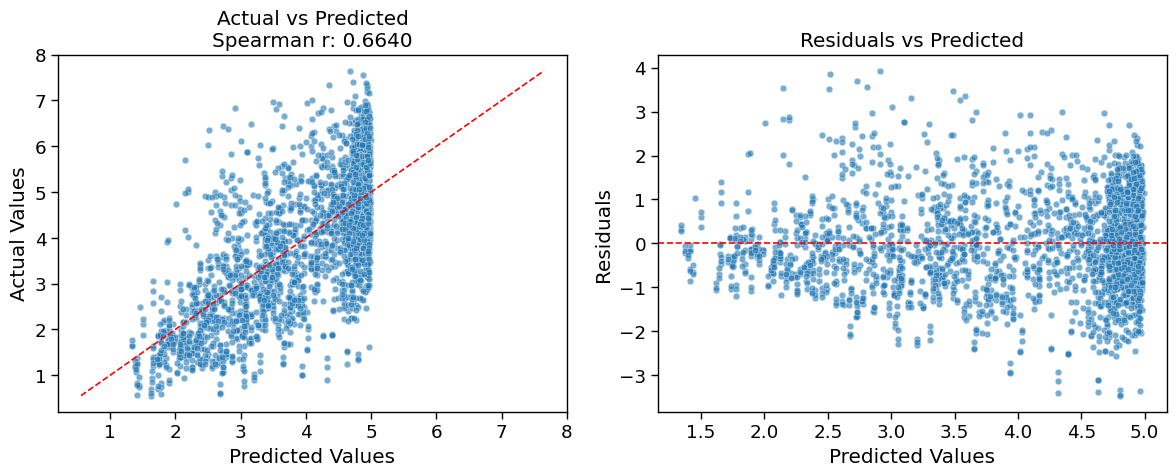

In [54]:
plot_prediction_error(tok_dds['valid']['labels'], preds_output_eval.predictions.squeeze())

Spearman r value of 0.6640 is decent but indicates room for improvement, especially in capturing the trend across the entire range of predictions. The spread increases as the predicted values increase, suggesting potential issues with variance in the model's predictions as the value of the target increases. The higher values reflect lower binding affinity and hence actual values from noisy measurements.

## Error analysis

We can investigate our model's predictions a little bit further by sorting the validation samples by the model loss.

In [55]:
# Function to perform a forward pass and calculate loss without updating model weights

from torch.nn.functional import mse_loss

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokz.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = output.logits
        loss = mse_loss(pred_label.squeeze(), batch["labels"].squeeze().to(device),
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy().squeeze()}

In [56]:
# Using the map() method once more, we can apply this function to get the losses for all the samples

# Convert our dataset back to PyTorch tensors
tok_dds['valid'].set_format("torch",
                            columns=["input_ids", "attention_mask", "labels"])

# Set the device to use
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Applying the forward_pass_with_label function to compute losses
tok_dds['valid'] = tok_dds['valid'].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2606 [00:00<?, ? examples/s]

In [57]:
# Calculating Spearman's rho to measure correlation between predictions and actual labels
from scipy import stats
rho, p_value = stats.spearmanr(a=tok_dds['valid']['predicted_label'],
                               b=tok_dds['valid']['labels'], axis=0)
print(f"Spearman's rho: {rho:.3f}, P-value: {p_value:.3f}")

Spearman's rho: 0.664, P-value: 0.000


In [58]:
# Convert dataset back to pandas for easy manipulation and visualization
tok_dds['valid'].set_format("pandas")
df_eval = tok_dds['valid'][:]

In [59]:
# Ensure input_ids are correctly formatted and decode them
def decode_and_unspace(input_ids):
    # Ensure input_ids is a list (not a tensor or numpy array)
    if not isinstance(input_ids, list):
        input_ids = input_ids.tolist()  # Convert tensors or numpy arrays to list

    # Decode using the tokenizer and remove spaces
    decoded_sequence = tokz.decode(input_ids, skip_special_tokens=True)
    return decoded_sequence.replace(" ", "")

In [60]:
# Decoding input_ids to actual sequences
df_eval['hc'] = df_eval['input_ids'].map(decode_and_unspace)
# Calculate number of mutations
df_eval['num_muts'] = df_eval['hc'].apply(lambda x: len(Levenshtein.editops(wt_14VH, x)))

In [61]:
# data samples with the highest losses
df_eval_high_loss = df_eval.sort_values("loss", ascending=False).head(500)

# let's also look at the predictions with the smallest loss
df_eval_low_loss = df_eval.sort_values("loss", ascending=True).head(500)

### Samples with highest losses

In [62]:
# look at the data samples with the highest losses
df_eval_high_loss.head(10)[['hc', 'loss', 'predicted_label', 'labels', 'num_muts']]

,hc,loss,predicted_label,labels,num_muts
637,EVQLVETGGGLVQPGGSLRLSCAASGFTLGSYGISWVRQAPGKGPE...,15.426209,2.912109,6.839731,3
845,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,14.769565,2.519531,6.362650,3
816,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,13.762646,2.726562,6.436367,2
2601,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,12.714350,2.810547,6.376265,3
837,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,12.604593,2.140625,5.690920,3
2593,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,12.351235,2.505859,6.020292,3
566,EVQLVETGGGLVQPGGSLRLSCAASGFTLDSYGISWVRQAPGKGPE...,12.087764,3.482422,6.959168,3
672,EVQLVETGGGLVQPGGSLRLSCAASGFTYNSYGTSWVRQAPGKGPE...,12.012515,4.804688,1.338780,2
2441,EVQLVETGGGLVQPGGSLRLSCAASGFTYNSYGTSWVRQAPGKGPE...,11.881925,4.804688,1.357671,2
827,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,11.669439,4.316406,0.900350,3


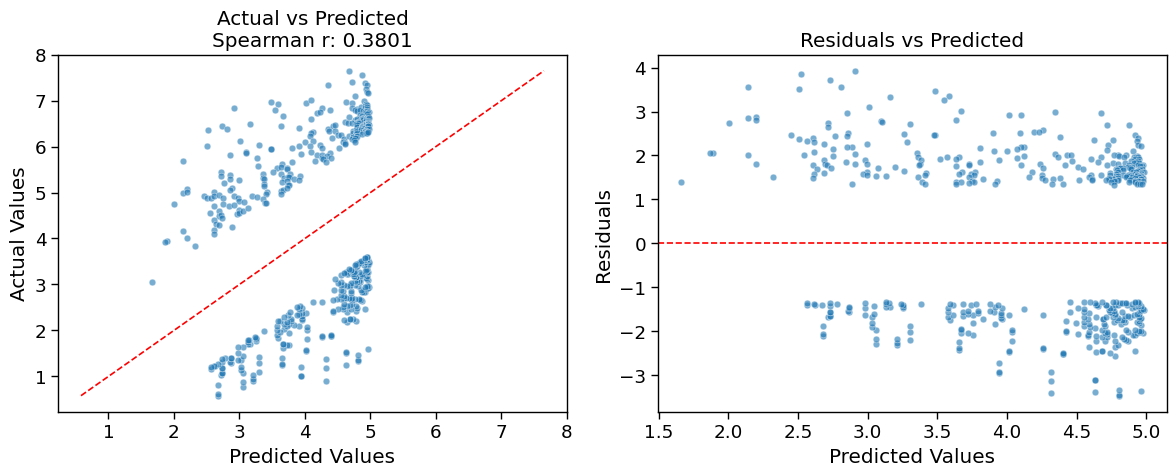

In [63]:
plot_prediction_error(df_eval_high_loss['labels'].values, df_eval_high_loss['predicted_label'].values)

### Samples with lowest losses

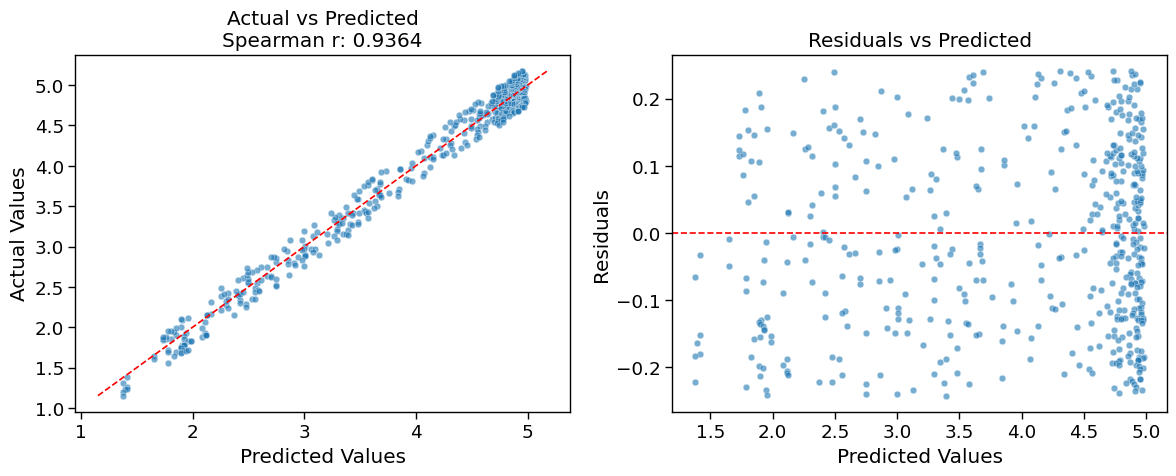

In [64]:
plot_prediction_error(df_eval_low_loss['labels'].values, df_eval_low_loss['predicted_label'].values)

## Prediction on test set

In [65]:
# Using the trained model to predict the test dataset
preds_output_test = trainer.predict(tok_dds['test'])

# Extracting predictions and squeezing the last dimension
y_preds_test = preds_output_test.predictions.squeeze(-1)

# Add predictions as a new column to the dataset
tok_dds['test'] = tok_dds['test'].add_column("predicted_labels", y_preds_test)

# Convert the Hugging Face dataset to a pandas DataFrame
test_df_with_preds = tok_dds['test'].to_pandas()

# Specify output CSV file path
output_csv_path = 'Ab14H_with_preds.csv'

# Export the DataFrame to CSV, without the index
test_df_with_preds.to_csv(output_csv_path, index=False)

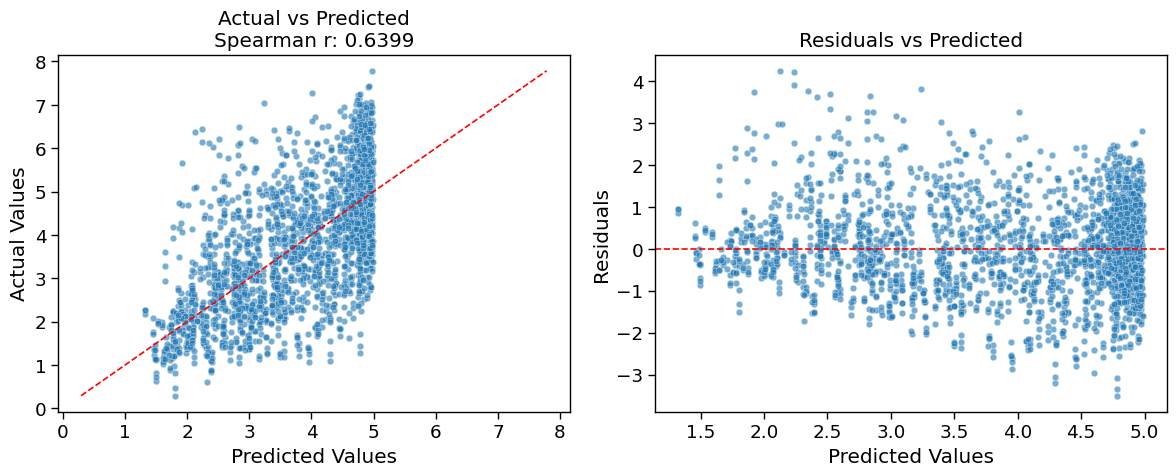

In [66]:
plot_prediction_error(tok_dds['test']['labels'], preds_output_test.predictions.squeeze())

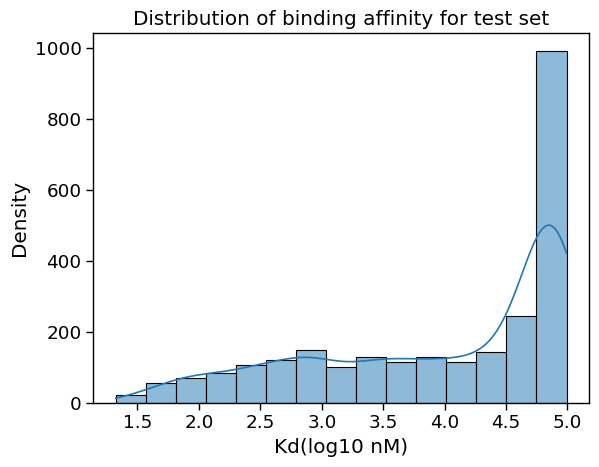

In [67]:
# Visualize predictions on test set
sns.histplot(y_preds_test, kde=True)
plt.xlabel('Kd(log10 nM)')
plt.ylabel('Density')
plt.title("Distribution of binding affinity for test set");

## Inference from the model

In [68]:
# Load the trained model
model_ckpt_trained = "models/esm2_t33_650M_UR50D-finetuned-Ab14H-v1"
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt_trained)

# Set the device to use
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Ensure the model is on the correct device
model.to(device)
model.eval()  # Set the model to evaluation mode

EsmForSequenceClassification(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 1280, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 1280, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-32): 33 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=1280, out_features=1280, bias=True)
              (key): Linear(in_features=1280, out_features=1280, bias=True)
              (value): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((1280,

In [69]:
# Retrieve the heavy chain sequence for a single entry
text = wt_14VH
inputs = tokz(text, return_tensors="pt")

# Print input tensor shapes for verification
print(f"Input tensor shape: {inputs['input_ids'].size()}")

# Decode to check if the input was tokenized correctly
decoded_input = tokz.decode(inputs['input_ids'][0], skip_special_tokens=True).replace(" ", "")
print(f"Decoded input: {decoded_input}")

Input tensor shape: torch.Size([1, 120])
Decoded input: EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPEWVSVIYSDGRRTFYGDSVKGRFTISRDTSTNTVYLQMNSLRVEDTAVYYCAKGRAAGTFDSWGQGTLVTVSS


In [70]:
decoded_input == text

True

In [71]:
# Move all inputs to the same device as the model
inputs = {k:v.to(device) for k,v in inputs.items()}

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

SequenceClassifierOutput(loss=None, logits=tensor([[1.8774]], device='cuda:0'), hidden_states=None, attentions=None)


In [75]:
# What's the actual values for the same sequence?
dfs_copies1['train']['num_muts'] = dfs_copies1['train']['hc'].apply(lambda x:
                                len(Levenshtein.editops(wt_14VH, x)))
dfs_copies1['train'][dfs_copies1['train']['num_muts'] == 0]

,mata_description,matalpha_description,pred_aff,sample_name,assay,random_seed,alpha,aa_seq,hc,num_muts
19451,AAYL49_29236,MIT_Target,2.430423,1,1,1,0.735617,GFTLNSYGISWVRQAPGKGPEWVSVIYSDGRRTFYGDSVKGRFTIS...,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,0
42044,AAYL49_29236,MIT_Target,2.346744,2,1,1,0.685117,GFTLNSYGISWVRQAPGKGPEWVSVIYSDGRRTFYGDSVKGRFTIS...,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,0
61728,AAYL49_29236,MIT_Target,2.370827,3,1,1,0.674095,GFTLNSYGISWVRQAPGKGPEWVSVIYSDGRRTFYGDSVKGRFTIS...,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,0
